In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost

import torch
import beacon

/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/torchvision/0.12.0/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /cvmfs/sft.cern.ch/lcg/releases/torchvision/0.12.0-2ee13/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


-----------
Data Loading and Visualisation
---------

In [2]:
KMU2GIB_EVENT_COUNT = 20000
KMU2GSDINT_RATIO = 0.0419
K2PI_RATIO = 33.3387
KMU3_RATIO = 5.4048

In [3]:
matplotlib.rcParams['figure.figsize'] = (9, 6)
# plt.style.use('dark_background')

In [4]:
def read_dir(directory):
    # Initialize an empty list to store the dataframes
    dfs = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Read the CSV file into a dataframe
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath)
            except:
                print(f'Error reading {filepath}')
                continue
            
            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [5]:
kmu2gib_df = read_dir("/eos/user/y/yuanye/Analysis/data/kmu2gibdata")
kmu2gsd_df = read_dir("/eos/user/y/yuanye/Analysis/data/kmu2gsddata")
kmu2gintm_df = read_dir("/eos/user/y/yuanye/Analysis/data/kmu2gintmdata")
k2pi_df = read_dir("/eos/user/y/yuanye/Analysis/data/k2pidata")
kmu3_df = read_dir("/eos/user/y/yuanye/Analysis/data/kmu3data")

Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out1.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out17.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out18.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out2.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out21.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out24.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out3.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out32.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out4.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out6.csv
Error reading /eos/user/y/yuanye/Analysis/data/k2pidata/out9.csv


In [6]:
k2pi_df['CumulativeEventCount'] = k2pi_df['EventCount'].cumsum()
kmu3_df['CumulativeEventCount'] = kmu3_df['EventCount'].cumsum()
kmu2gsd_df['CumulativeEventCount'] = kmu2gsd_df['EventCount'].cumsum()
kmu2gintm_df['CumulativeEventCount'] = kmu2gintm_df['EventCount'].cumsum()
kmu2gib_df['CumulativeEventCount'] = kmu2gib_df['EventCount'].cumsum()

In [7]:
k2pi_df["CumulativeEventCount"].max(), kmu3_df["CumulativeEventCount"].max()

(1490569, 7033119)

In [8]:
kmu2gsd_df_sub = kmu2gsd_df[kmu2gsd_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gintm_df_sub = kmu2gintm_df[kmu2gintm_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gsdintm_df_sub = pd.concat([kmu2gsd_df_sub, kmu2gintm_df_sub], ignore_index=True)
k2pi_df_sub = k2pi_df[k2pi_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * K2PI_RATIO]
kmu3_df_sub = kmu3_df[kmu3_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * KMU3_RATIO]

In [9]:
# calculate the acceptance ratio
kmu2gib_acceptance = len(kmu2gib_df) / KMU2GIB_EVENT_COUNT
kmu2gsd_acceptance = len(kmu2gsd_df) / kmu2gsd_df["CumulativeEventCount"].max()
kmu2gintm_acceptance = len(kmu2gintm_df) / kmu2gintm_df["CumulativeEventCount"].max()
k2pi_acceptance = len(k2pi_df) / k2pi_df["CumulativeEventCount"].max()
kmu3_acceptance = len(kmu3_df) / kmu3_df["CumulativeEventCount"].max()

print("kmu2gib Acceptance: ", kmu2gib_acceptance)
print("kmu2gsd- Acceptance: ", kmu2gsd_acceptance)
print("kmu2gint- Acceptance: ", kmu2gintm_acceptance)
print("k2pi Acceptance: ", k2pi_acceptance)
print("kmu3 Acceptance: ", kmu3_acceptance)

kmu2gib Acceptance:  0.22035
kmu2gsd- Acceptance:  0.20048055263553086
kmu2gint- Acceptance:  0.20490367775831875
k2pi Acceptance:  0.008956982199415122
kmu3 Acceptance:  0.008213710019693964


In [10]:
# Add mode column for classification
# 0: kmu2gib, 1: kmu2gsd, 2: kmu2gintm, 3: k2pi, 4: kmu3
kmu2gib_df["Mode"] = 0
kmu2gsdintm_df_sub["Mode"] = 1
k2pi_df_sub["Mode"] = 2
kmu3_df_sub["Mode"] = 3

combined_df = pd.concat([kmu2gib_df, kmu2gsdintm_df_sub, k2pi_df_sub, kmu3_df_sub], ignore_index=True)

/tmp/yuanye/ipykernel_3654572/109178695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k2pi_df_sub["Mode"] = 2
/tmp/yuanye/ipykernel_3654572/109178695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmu3_df_sub["Mode"] = 3


In [11]:
combined_df.insert(0, "GTKMomentum", np.sqrt(combined_df["GTKMomentumX"]**2 + combined_df["GTKMomentumY"]**2 + combined_df["GTKMomentumZ"]**2))
combined_df.insert(5, "MuonMomentumPrime", np.sqrt(combined_df["MuonMomentumPrimeX"]**2 + combined_df["MuonMomentumPrimeY"]**2 + combined_df["MuonMomentumPrimeZ"]**2))
combined_df.insert(10, "MissingMomentum", np.sqrt(combined_df["MissingMomentumX"]**2 + combined_df["MissingMomentumY"]**2 + combined_df["MissingMomentumZ"]**2))

In [12]:
# Remove unnecessary columns for classification
combined_df = combined_df.drop(columns=["NLKrCells", "NLKrClusters", "NVertices", "NTracks", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "GTKEnergy", "GTKGamma", "GTKBeta", "EventCount", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "MuonMomentumX", "MuonMomentumY", "MuonMomentumZ", "MuonMomentumPrimeX", "MuonMomentumPrimeY", "MuonMomentumPrimeZ", "MissingMomentumX", "MissingMomentumY", "MissingMomentumZ", "CDAAfterCut", "CumulativeEventCount", "CDA", "TrackTime", "QChi2Track"])

In [13]:
X = combined_df.drop(columns=["Mode"])
y = combined_df["Mode"]

----------
Machine Learning
----------

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Decision Tree
---------------

In [15]:
# Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [16]:
y_pred_tree = dtree.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_tree)))

Accuracy: 0.9079328314997105


In [17]:
report = classification_report(y_test, y_pred_tree, target_names=['kmu2gib', 'kmu2gsdintm', 'k2pi', 'kmu3'])
print(report)

              precision    recall  f1-score   support

     kmu2gib       0.90      0.93      0.92      1356
 kmu2gsdintm       0.11      0.14      0.12        36
        k2pi       0.95      0.94      0.95      1805
        kmu3       0.73      0.66      0.69       257

    accuracy                           0.91      3454
   macro avg       0.68      0.67      0.67      3454
weighted avg       0.91      0.91      0.91      3454



Random Forest
----------

In [18]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
y_pred_forest = forest.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_forest)))

Accuracy: 0.9389114070642733


In [20]:
print(classification_report(y_test, y_pred_forest, target_names=['kmu2gib', 'kmu2gsdintm', 'k2pi', 'kmu3']))

              precision    recall  f1-score   support

     kmu2gib       0.93      0.96      0.95      1356
 kmu2gsdintm       0.25      0.03      0.05        36
        k2pi       0.96      0.97      0.97      1805
        kmu3       0.79      0.69      0.74       257

    accuracy                           0.94      3454
   macro avg       0.73      0.66      0.68      3454
weighted avg       0.93      0.94      0.93      3454



Gradient Boosted Decision Trees
-------------------------------

In [21]:
boosted_tree = GradientBoostingClassifier(n_estimators=100)
boosted_tree.fit(X_train, y_train)

In [ ]:
y_pred_boosted_tree = boosted_tree.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_boosted_tree)))

Accuracy: 0.9438332368268674


In [ ]:
print(classification_report(y_test, y_pred_boosted_tree, target_names=['kmu2gib', 'kmu2gsdintm', 'k2pi', 'kmu3']))

              precision    recall  f1-score   support

     kmu2gib       0.94      0.96      0.95      1356
 kmu2gsdintm       0.25      0.08      0.12        36
        k2pi       0.97      0.98      0.98      1805
        kmu3       0.80      0.73      0.76       257

    accuracy                           0.94      3454
   macro avg       0.74      0.69      0.70      3454
weighted avg       0.94      0.94      0.94      3454



Extreme Gradient Boosting
-------------------------

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
y_pred_xgb = xgb.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_xgb)))

Accuracy: 0.9415170816444702


In [ ]:
print(classification_report(y_test, y_pred_xgb, target_names=['kmu2gib', 'kmu2gsdintm', 'k2pi', 'kmu3']))

              precision    recall  f1-score   support

     kmu2gib       0.93      0.96      0.94      1356
 kmu2gsdintm       0.00      0.00      0.00        36
        k2pi       0.97      0.98      0.97      1805
        kmu3       0.83      0.72      0.77       257

    accuracy                           0.94      3454
   macro avg       0.68      0.67      0.67      3454
weighted avg       0.93      0.94      0.94      3454



Deep Neural Networks
--------------------

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)

In [ ]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([8058, 17]), torch.Size([8058]))

In [ ]:
class DNN(beacon.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, out_features)
        self.dropout = torch.nn.Dropout(0.45)
        self.classifier = torch.nn.Softmax(dim=1)
        self.ReLU = torch.nn.ReLU()
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        x = self.classifier(x)
        return x

In [ ]:
dnn = DNN(X_train_tensor.shape[1], 4)
dnn.compile(optimiser=torch.optim.SGD, device="cuda")

In [ ]:
losses = dnn.fit_tensor(X_train_tensor, y_train_tensor, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.57 GiB of which 8.75 MiB is free. Process 2322271 has 14.14 GiB memory in use. Process 2518239 has 266.00 MiB memory in use. Including non-PyTorch memory, this process has 160.00 MiB memory in use. Of the allocated memory 16.60 MiB is allocated by PyTorch, and 9.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

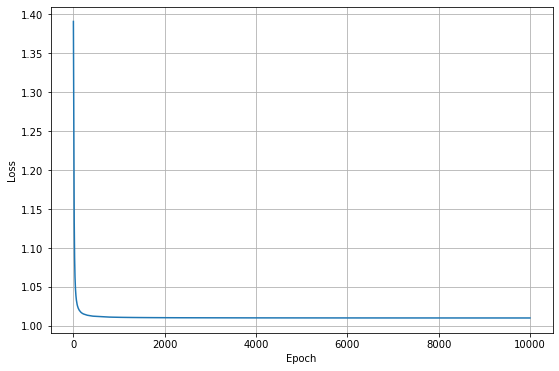

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [ ]:
y_pred_dnn = dnn.predict(torch.tensor(X_test.values, dtype=torch.float32))
y_pred_dnn = np.argmax(y_pred_dnn.cpu().numpy(), axis=1)

In [ ]:
accuracy_score(y_test, y_pred_dnn)

0.7368479714667856